<a href="https://colab.research.google.com/github/yfqian95/JWAS.jl/blob/master/Aug3_Bayesian_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia CSV DataFrames Random Statistics Distributions LinearAlgebra SparseArrays Printf JWAS"  # CSV DataFrames Random Statistics JWAS Distributions LinearAlgebra
JULIA_PACKAGES_IF_GPU=""
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.1 on the current Colab Runtime...
2022-08-03 16:36:43 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.1-linux-x86_64.tar.gz [123374573/123374573] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package CSV...
Installing Julia package DataFrames...
Installing Julia package Random...
Installing Julia package Statistics...
Installing Julia package Distributions...
Installing Julia package LinearAlgebra...
Installing Julia package SparseArrays...
Installing Julia package Printf...
Installing Julia package JWAS...


In [1]:
versioninfo()

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 4


In [ ]:
using Pkg
Pkg.add("Plots")
using Plots,Statistics,DataFrames, Random

In [ ]:
Random.seed!(123)
mean_male   = 170
sd_male     = 5
mean_female = 159
sd_female   = 5
nind_male   = 1200
nind_female = 800
males       = mean_male .+ randn(nind_male)*sd_male
females     = mean_female .+ randn(nind_female)*sd_female
data=[convert.(Int,round.(males))  fill("male",nind_male)
      convert.(Int,round.(females)) fill("female",nind_female)];
data = DataFrame(height=data[:,1],gender=data[:,2])
first(data,5)

,height,gender
,Any,Any
1,174,male
2,164,male
3,164,male
4,168,male
5,171,male


In [ ]:
plot(data[data[!,:gender].=="male",:height],seriestype=:histogram,xlabel=:height,legend=:none) 
plot!(data[data[!,:gender].=="female",:height],seriestype=:histogram) 

In [ ]:
using Distributions
μ = [1.0;2.0]
V = [1.0 0.5;0.5 2.0] #V is variance for each variable

x     = [0.0;0.0] #initial value
niter = 50000 #number of iteration
c     = 0 #number of times that the condition happens 

for i in 1:niter
    mean12 = μ[1]+V[1,2]/V[2,2]*(x[2]-μ[2])
    var12  = V[1,1]-V[1,2]^2/V[2,2]
    
    x[1] = mean12+randn()*sqrt(var12)
    
    mean21 = μ[2]+V[2,1]/V[1,1]*(x[1]-μ[1])
    var21  = V[2,2]-V[2,1]^2/V[1,1]
    
    x[2] = mean21+randn()*sqrt(var21)
    
    if x[1] > 1 && x[2] > 2
        c += 1
    end
end

c/niter

0.3087

In [ ]:
using Distributions
μ = [1;2]
V = [1.0 0.5;0.5 2.0]

x     = [0;0]
niter = 50000
c     = 0

for i in 1:niter
    x = rand(MvNormal(μ, V))
    if x[1] > 1 && x[2] > 2
        c += 1
    end
end

c/niter

0.30886

In [2]:
function Gibbs!(A,x,b,varRes::Float64,nIter::Int64;outFreq=100)
    n = size(x,1)
    xMean = zeros(n)
    for iter = 1:nIter
        if iter%outFreq==0
            println("at sample: ",iter)
        end
        for i=1:n
            cVarInv = 1.0/A[i,i]
            cMean   = cVarInv*(b[i] - A[:,i]'x) + x[i]
            x[i]    = randn()*sqrt(cVarInv*varRes) + cMean
        end
        xMean += (x - xMean)/iter
    end
    return xMean
end

Gibbs! (generic function with 1 method)

In [11]:
#using Pkg
#Pkg.add("Plots")
#Pkg.add("ProgressMeter")
using DataFrames, SparseArrays, LinearAlgebra, Random, JWAS, CSV, Printf, Statistics, Plots, Distributions, ProgressMeter

mutable struct ModelTerm
    trmString::AbstractString
    startPos::Int64
    endPos::Int64
    randomType::String
end

mutable struct RandomEffect
    modelTermVec::Array{ModelTerm,1}
    νpr::Float64
    Spr::Array{Float64,2}
    Vi::Array{Float64,2}
    meanV::Array{Float64,2}
    Ai
    estimate::Bool                # new determine if estimated or not estimated 
    outSamples::Bool              # new
    outFreq::Int64                # new
    outStream                     # new
end

mutable struct MME
    modelEquation::AbstractString           #"y = A + B + A*B"
    covVec::Array{String}                   #["age"]
    modelTermVec::Array{ModelTerm,1}        #[modelTerm("A") , modelTerm("A*B")]
    modelTermDict::Dict{AbstractString,ModelTerm}
    randomEffectsVec::Array{RandomEffect,1} #[RandomEffect("Ind"), RandomEffect("Mat")]
    ped                                     # false or a pedigee structure defined in JWAS.PedModule
    depVar::Symbol                          #:y 
    X::SparseMatrixCSC{Float64,Int64}       #design matrix
    mmeLhs::SparseMatrixCSC{Float64,Int64}  #left-hand side for MME
    mmeRhs::Array{Float64,1}                #right-hand side for MME
    mmeSpl::Array{Float64,1}                #sample of location effects              # new
    varRes::Float64                         #residual variance 
    νRes::Float64                           #prior degrees of freedom for varRes     # new
    SRes::Float64                           #prior scale parameter for resVar        # new
    y::Array{Float64,1}                     #vector of values for dependent variable # new
    meanVarRes::Float64                     
end 

function ModelTerm(str::AbstractString)
    ModelTerm(str,0,0,"fixed")
end  

ModelTerm

In [12]:
function initMME(modelEquation::AbstractString,varRes;νRes=5.0)  # "y = A + A*B"
    if modelEquation==""
        error("modelEquation is empty\n")
    end
    leftRight  = split(modelEquation,"=")       # "y", "A+A*B"
    depVar     = Symbol(strip(leftRight[1]))    # :y
    modelParts = strip(leftRight[2])            #"A+A*B" 
    termsVec   = split(modelParts,"+")          #"A","A*B"
    modelTermVec = [ModelTerm(strip(trmStr)) for trmStr in termsVec]
    modelTermDict = Dict{AbstractString,ModelTerm}()
    for i in modelTermVec
        modelTermDict[i.trmString] = i
    end
    randomEffectsVec = []
    ped = false
    covVec = []
    X = spzeros(0,0)
    mmeLhs = spzeros(0,0)
    mmeRhs = []
    mmeSol = []
    y      = []
    SRes   = varRes*νRes/(νRes-2)                            # new
    meanVarRes = 0.0                                         # new
    return MME(modelEquation,covVec,modelTermVec,modelTermDict,randomEffectsVec,ped,
               depVar,X,mmeLhs,mmeRhs,mmeSol,varRes,νRes,SRes,y,meanVarRes)
end 

initMME (generic function with 1 method)

20. Extensions for Models with SNP Covariates
Here, we will see how substitution effects of SNPs can be included in the model as random effects in the model. In multiple-trait analyses, a single command will be used to include SNP effects in all the models.
y=Xb+Ma+e
M=genotype covariate matrix, the AA,Aa,aa, 2,1,0

20.2.1. Single-trait model
y=xb+zu+wa+e (sample locus)


y(corrected)=wa+e (SNP effects), w is marker effect



In [13]:
#15.2 e-book simulation of data
using Distributions, Printf, Random, Plots

In [14]:
Random.seed!(123)
n = 20 #number of observations
k = 1  #number of covariates


X =[ones(n) rand(Binomial(2,0.5), n,k)]
betaTrue = [1,2] #the true value for intercept is 1 and the true value for slope is 2, can be any numbers 
y = X*betaTrue + randn(n);

In [17]:
X

20×2 Matrix{Float64}:
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  2.0
 1.0  1.0
 1.0  1.0
 1.0  0.0
 1.0  2.0
 1.0  2.0
 1.0  1.0
 1.0  0.0
 1.0  2.0
 1.0  1.0
 1.0  1.0
 1.0  2.0
 1.0  1.0
 1.0  1.0
 1.0  2.0
 1.0  0.0
 1.0  0.0

In [18]:
y

20-element Vector{Float64}:
 3.2322909372677087
 1.7346859294419197
 1.8240344309010028
 4.8616010751306
 2.2098941800887135
 4.926394978510115
 1.6775969230064935
 3.5179284176316017
 4.231090179257908
 3.732009280123085
 2.4276128742019525
 3.9068369320718115
 4.444571698810035
 2.818122314774419
 5.789017052313964
 1.011176271479106
 4.0006949009778054
 3.754261872084562
 1.612862260841199
 0.8639087285726282

In [19]:
XPX = X'X
rhs = X'y
XPXi= inv(XPX)

2×2 Matrix{Float64}:
  0.173469  -0.112245
 -0.112245   0.102041

In [20]:
betaHat = XPXi*rhs

2-element Vector{Float64}:
 1.6448290333098954
 1.3490913896040322

In [21]:
eHat = y - X*betaHat #the residual variance=y-yhat
resVar = eHat'eHat/(n-2)

1.0999961951362645

In [22]:
niter                 = 100_000       # number of samples
b                     = [0.0, 0.0]    # starting values, first 1 is intercept and second is slope
sumB                  = [0.0, 0.0]    # a vector used to calculate posterior means
samples_b1            = zeros(niter)  # a vector to save MCMC samples for b1
samples_b2            = zeros(niter)  # a vector to save MCMC samples for b2

for iter = 1:niter
    
    # sampling intercept
    w    = y - X[:,2] * b[2]                  # w0 = y - x2*b2
    x    = X[:,1]                             # x1, a column of 1s
    xpxi = 1/(x'x)                            # 
    bHat = (xpxi*x'w)                         # x1'w0/x1'x1
    b[1] = rand(Normal(bHat, sqrt(xpxi*1.0))) # known residual variance = 1 
    
    # sampling slope
    w    = y - X[:,1]*b[1]                    # w1 = y - x1*b1
    x    = X[:,2]                             # x2
    xpxi = 1/(x'x)                            # 
    bHat = (xpxi*x'w)                         # x2'w1/x2'x2
    b[2] = rand(Normal(bHat, sqrt(xpxi*1.0))) # known residual variance = 1  
    
    # save MCMC samples from the posterior distribution of b1 and b2
    samples_b1[iter] = b[1] 
    samples_b2[iter] = b[2]

    if ((iter%10_000) == 0) #print out posterior mean for b1 and b2
        @printf("Intercept = %6.3f \n", sum(samples_b1)/iter)
        @printf("Slope     = %6.3f \n", sum(samples_b2)/iter)
    end
end

Intercept =  1.635 
Slope     =  1.356 
Intercept =  1.638 
Slope     =  1.355 
Intercept =  1.640 
Slope     =  1.352 
Intercept =  1.642 
Slope     =  1.351 
Intercept =  1.641 
Slope     =  1.352 
Intercept =  1.640 
Slope     =  1.353 
Intercept =  1.637 
Slope     =  1.355 
Intercept =  1.638 
Slope     =  1.355 
Intercept =  1.640 
Slope     =  1.353 
Intercept =  1.639 
Slope     =  1.354 


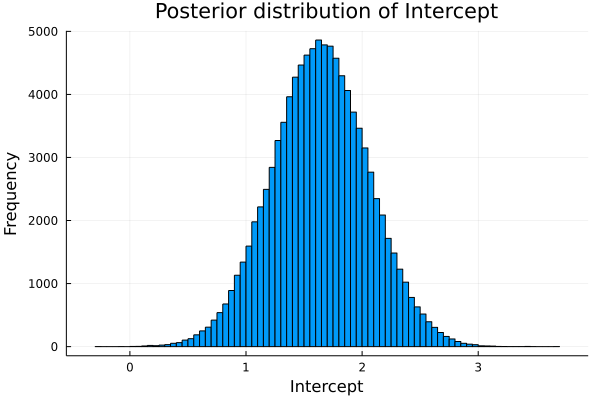

Your GR installation is incomplete. Rerunning build step for GR package.


┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
ERROR: LoadError: InitError: could not load library "/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so"
/root/.julia/artifacts/a84cc58d5161b950f268bb562e105bbbf4d6004a/lib/libGL.so: undefined symbol: _glapi_tls_Current
Stacktrace:
  [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
    @ Base.Libc.Libdl ./libdl.jl:117
  [2] dlopen(s::String, flags::UInt32)
    @ Base.Libc.Libdl ./libdl.jl:117
  [3] macro expansion
    @ ~/.julia/packages/JLLWrappers/QpMQW/src/products/library_generators.jl:54 [inlined]
  [4] __init__()
    @ Libglvnd_jll ~/.julia/packages/Libglvnd_jll/pJrjy/src/wrappers/x86_64-linux-gnu.jl:22
  [5] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base ./loading.jl:768
  [6] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base ./loading.jl:854
  [7] _require(pkg::Base.PkgId)
    @ Base ./loading.jl:1097

In [23]:
histogram(samples_b1[101:end],
    title  = "Posterior distribution of Intercept",
    ylabel = "Frequency",
    xlabel = "Intercept",
    labels = false
)

In [24]:
#15.4.3. Full-conditional Posterior for unkown residual variance
niter                 = 100_000       # number of samples
b                     = [0.0, 0.0]    # starting values
samples_b1            = zeros(niter)  # a vector to save MCMC samples for b1
samples_b2            = zeros(niter)  # a vector to save MCMC samples for b2
samples_σ2            = zeros(niter)  # a vector to save MCMC samples for residual variance

#For residual variances
σ2    = 1.0
νRes  = 5
S2Res = σ2*(νRes - 2)/νRes
n     = size(X,1)

for iter = 1:niter
    
    # sampling intercept
    w    = y - X[:,2] * b[2]                  # w0 = y - x2*b2
    x    = X[:,1]                             # x1, a column of 1s
    xpxi = 1/(x'x)                            # 
    bHat = (xpxi*x'w)                         # x1'w0/x1'x1
    b[1] = rand(Normal(bHat, sqrt(xpxi*σ2)))  ### unknown residual variance, don't know residual variance
    
    # sampling slope
    w    = y - X[:,1]*b[1]                    # w1 = y - x1*b1
    x    = X[:,2]                             # x2
    xpxi = 1/(x'x)                            # 
    bHat = (xpxi*x'w)                         # x2'w1/x2'x2
    b[2] = rand(Normal(bHat, sqrt(xpxi*σ2)))  ### unknown residual variance  
   
    # sampling residual variance
    e       = y - X*b                                   ### 
    SSE     = e'e                                       ###
    σ2      = (SSE + νRes*S2Res)/rand(Chisq(n+νRes))    ###
    
    # save MCMC samples from the posterior distribution of b1 and b2
    samples_b1[iter] = b[1] 
    samples_b2[iter] = b[2]
    samples_σ2[iter] = σ2 

    if ((iter%10_000) == 0) #print out posterior mean for b1 and b2
        @printf("Intercept = %6.3f \n", sum(samples_b1)/iter)
        @printf("Slope     = %6.3f \n", sum(samples_b2)/iter)
        @printf("σ2        = %6.3f \n", sum(samples_σ2)/iter)
    end
end

Intercept =  1.640 
Slope     =  1.352 
σ2        =  1.091 
Intercept =  1.643 
Slope     =  1.348 
σ2        =  1.088 
Intercept =  1.644 
Slope     =  1.348 
σ2        =  1.086 
Intercept =  1.639 
Slope     =  1.351 
σ2        =  1.086 
Intercept =  1.640 
Slope     =  1.352 
σ2        =  1.085 
Intercept =  1.642 
Slope     =  1.350 
σ2        =  1.086 
Intercept =  1.641 
Slope     =  1.351 
σ2        =  1.086 
Intercept =  1.641 
Slope     =  1.351 
σ2        =  1.086 
Intercept =  1.641 
Slope     =  1.352 
σ2        =  1.086 
Intercept =  1.641 
Slope     =  1.351 
σ2        =  1.085 


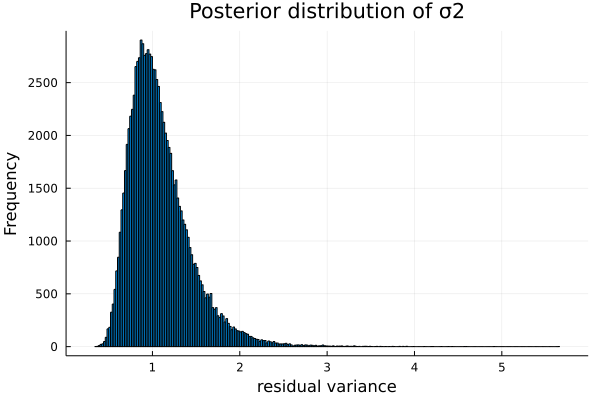

In [25]:
histogram(samples_σ2[101:end], 
    title  = "Posterior distribution of σ2",
    ylabel = "Frequency",
    xlabel = "residual variance",
    labels = false
)        

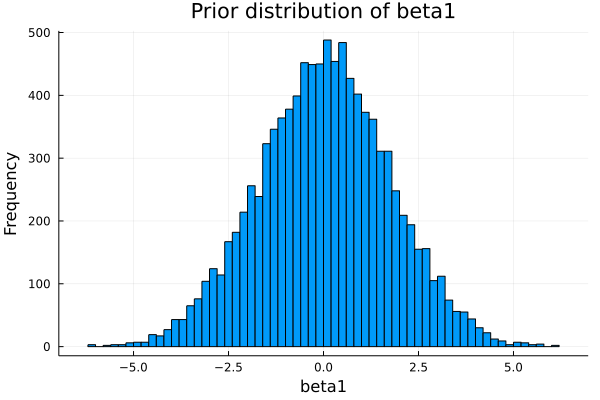

In [26]:
prior = randn(10_000)*sqrt(3.0)
histogram(prior, 
    title  = "Prior distribution of beta1",
    ylabel = "Frequency",
    xlabel = "beta1",
    labels = false
)

In [27]:
n = 200 # number of observations
k = 1   # number of covariates

x = rand([0,1,2],(n,k))
X = [ones(Int64,n) x]

betaTrue = [1,2]
y        = X*betaTrue+ randn(n)*sqrt(5.0);

In [28]:
niter                 = 10_000       # number of samples
b                     = [0.0, 0.0]    # starting values
samples_b1            = zeros(niter)  # a vector to save MCMC samples for b1
samples_b2            = zeros(niter)  # a vector to save MCMC samples for b2
samples_σ2            = zeros(niter)  # a vector to save MCMC samples for residual variance

#For residual variances
σ2    = 1.0
νRes  = 5
S2Res = σ2*(νRes - 2)/νRes
n     = size(X,1)

#For random effect β1
vB1   = 3.0 #assume the variance for beta 1 is known


for iter = 1:niter
    # sampling intercept
    w    = y - X[:,2] * b[2]                  # w0 = y - x2*b2
    x    = X[:,1]                             # x1, a column of 1s
    xpxi = 1/(x'x)                            # 
    bHat = (xpxi*x'w)                         # x1'w0/x1'x1
    b[1] = rand(Normal(bHat, sqrt(xpxi*σ2)))  # unknown residual variance
    
    # sampling slope
    w    = y - X[:,1]*b[1]                    # w1 = y - x1*b1
    x    = X[:,2]                             # x2
    λ    = σ2/vB1                             ### NEW
    xpxi = 1/(x'x+λ)                          ### NEW 
    bHat = (xpxi*x'w)                         # x2'w1/(x2'x2 + Iλ)
    b[2] = rand(Normal(bHat, sqrt(xpxi*σ2)))  # unknown residual variance  
   
    # sampling residual variance
    e       = y - X*b
    SSE     = e'e
    σ2      = (SSE + νRes*S2Res)/rand(Chisq(n+νRes))
    
    # save MCMC samples from the posterior distribution of b1 and b2
    samples_b1[iter] = b[1] 
    samples_b2[iter] = b[2]
    samples_σ2[iter] = σ2 

    if ((iter%1_000) == 0) #print out posterior mean for b1 and b2
        @printf("Intercept = %6.3f \n", sum(samples_b1)/iter)
        @printf("Slope     = %6.3f \n", sum(samples_b2)/iter)
        @printf("σ2        = %6.3f \n", sum(samples_σ2)/iter)
    end
end

Intercept =  1.264 
Slope     =  1.716 
σ2        =  5.104 
Intercept =  1.287 
Slope     =  1.696 
σ2        =  5.085 
Intercept =  1.279 
Slope     =  1.701 
σ2        =  5.080 
Intercept =  1.281 
Slope     =  1.701 
σ2        =  5.076 
Intercept =  1.279 
Slope     =  1.702 
σ2        =  5.071 
Intercept =  1.278 
Slope     =  1.703 
σ2        =  5.070 
Intercept =  1.284 
Slope     =  1.698 
σ2        =  5.070 
Intercept =  1.282 
Slope     =  1.700 
σ2        =  5.072 
Intercept =  1.284 
Slope     =  1.699 
σ2        =  5.075 
Intercept =  1.283 
Slope     =  1.699 
σ2        =  5.076 


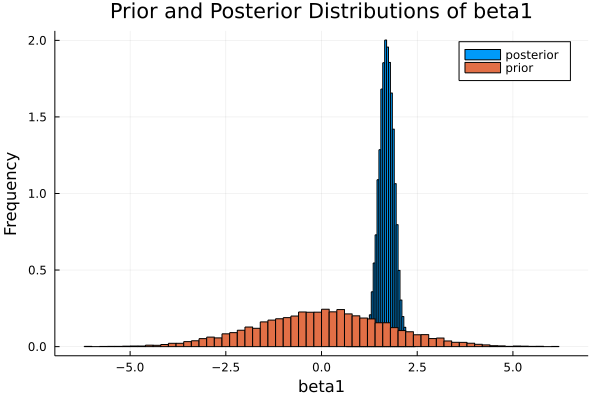

In [29]:
histogram([samples_b2; prior], group=repeat(["posterior", "prior"],inner=10_000), normalize=true,
    title  = "Prior and Posterior Distributions of beta1",
    ylabel = "Frequency",
    xlabel = "beta1"
)